## Проект: вариант 1
Представьте, что вы работаете в компании, которая разрабатывает мобильные игры. К вам пришел менеджер с рядом задач по исследованию нескольких аспектов мобильного приложения:

В первую очередь, его интересует показатель retention. Напишите функцию для его подсчета.
Помимо этого, в компании провели A/B тестирование наборов акционных предложений. На основе имеющихся данных определите, какой набор можно считать лучшим и на основе каких метрик стоит принять правильное решение.
Предложите метрики для оценки результатов последнего прошедшего тематического события в игре.
 
# Задание 1
Retention – один из самых важных показателей в компании. Ваша задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока). Данные лежат в папке shared и имеют следующую структуру:

In [1]:
# импорт необходимых библиотек
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import datetime
import os
from tqdm import tqdm
from statsmodels.stats.proportion import proportions_ztest
from IPython.display import display
from scipy import stats

In [2]:
# Получаем данные csv
reg_data_path = os.path.expanduser('~/shared/problem1-reg_data.csv')
auth_data_path = os.path.expanduser('~/shared/problem1-auth_data.csv')
# Проверка
print(f"Регистрации: {'OK' if os.path.exists(reg_data_path) else 'Не найден'}")
print(f"Авторизации: {'OK' if os.path.exists(auth_data_path) else 'Не найден'}")

Регистрации: OK
Авторизации: OK


In [3]:
reg_data = pd.read_csv(reg_data_path, sep=';')
auth_data = pd.read_csv(auth_data_path, sep=';')

In [4]:
# EDA для регистраций
print("\n=== Регистрации ===")
print(reg_data.info(), "\n")
print("Первые 5 строк:\n", reg_data.head(), "\n")
print("Дубликаты:", reg_data.duplicated().sum())
print("Пропуски:\n", reg_data.isnull().sum())


=== Регистрации ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype
---  ------  --------------    -----
 0   reg_ts  1000000 non-null  int64
 1   uid     1000000 non-null  int64
dtypes: int64(2)
memory usage: 15.3 MB
None 

Первые 5 строк:
       reg_ts  uid
0  911382223    1
1  932683089    2
2  947802447    3
3  959523541    4
4  969103313    5 

Дубликаты: 0
Пропуски:
 reg_ts    0
uid       0
dtype: int64


In [5]:
# EDA для авторизаций
print("\n=== Авторизации ===")
print(auth_data.info(), "\n")
print("Первые 5 строк:\n", auth_data.head(), "\n")
print("Дубликаты:", auth_data.duplicated().sum())
print("Пропуски:\n", auth_data.isnull().sum())


=== Авторизации ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9601013 entries, 0 to 9601012
Data columns (total 2 columns):
 #   Column   Dtype
---  ------   -----
 0   auth_ts  int64
 1   uid      int64
dtypes: int64(2)
memory usage: 146.5 MB
None 

Первые 5 строк:
      auth_ts  uid
0  911382223    1
1  932683089    2
2  932921206    2
3  933393015    2
4  933875379    2 

Дубликаты: 0
Пропуски:
 auth_ts    0
uid        0
dtype: int64


In [6]:
# Проверка на пользователей с оплатой до даты регистрации
merged = auth_data.merge(reg_data, how='left', on='uid')
invalid_dates = merged[merged['auth_ts'] < merged['reg_ts']]
print(f"Число записей с auth_ts < reg_ts: {len(invalid_dates)}")

# Удалим некорректные записи
merged = merged[merged['auth_ts'] >= merged['reg_ts']]

Число записей с auth_ts < reg_ts: 0


In [7]:
# Создаём копии исходных датафреймов
reg_df = reg_data.copy()
auth_df = auth_data.copy()

# Преобразуем timestamp в даты и переименовываем столбцы
reg_df["reg_date"] = pd.to_datetime(reg_df["reg_ts"], unit="s").dt.date
auth_df["auth_date"] = pd.to_datetime(auth_df["auth_ts"], unit="s").dt.date
reg_df.drop(columns="reg_ts", inplace=True)
auth_df.drop(columns="auth_ts", inplace=True)

# Объединяем таблицы по uid
# Так как регистрация фиксируется как первая авторизация, пользователи не теряются при left join'е —
# данные из reg_data присутствуют в auth_data в виде первой записи

user_activity = pd.merge(auth_df, reg_df, on="uid", how="left")[["uid", "reg_date", "auth_date"]]

In [8]:
# Просмотр первых 3 строк результата
print("Пример объединённых данных:\n", user_activity.head(3))

Пример объединённых данных:
    uid    reg_date   auth_date
0    1  1998-11-18  1998-11-18
1    2  1999-07-22  1999-07-22
2    2  1999-07-22  1999-07-25


#### Добавим колонку retention_day

In [9]:
# создаём новую таблицу
df_days = user_activity.copy()

# разница между auth_date и reg_date в днях
df_days["retention_day"] = (
    (pd.to_datetime(df_days["auth_date"]) - pd.to_datetime(df_days["reg_date"])) /
    np.timedelta64(1, "D")
).astype(int)

#### Задаём период анализа (30 дней регистрации)

In [10]:
# период регистрации и анализа входов
start_date = datetime.date(2020, 9, 1)
end_date = datetime.date(2020, 9, 23)

df_filtered = df_days.query(
    "reg_date >= @start_date and auth_date <= @end_date"
).copy()

#### Построение таблицы когорт

In [11]:
# группируем по дате регистрации и количеству дней с момента регистрации
cohorts_abs = (
    df_filtered
    .groupby(["reg_date", "retention_day"], as_index=False)
    .agg({"uid": "nunique"})
    .pivot(index="reg_date", columns="retention_day", values="uid")
)

In [12]:
# делим каждую строку на значение в нулевой день (день регистрации)
cohorts_norm = cohorts_abs.div(cohorts_abs[0], axis=0).round(4)

In [13]:
pd.set_option('display.max_columns', 15)

# показываем первые строки
print("Retention таблица (по дням):")
print(cohorts_norm.head())

Retention таблица (по дням):
retention_day   0       1       2       3       4       5       6   ...  \
reg_date                                                            ...   
2020-09-01     1.0  0.0202  0.0410  0.0422  0.0460  0.0643  0.0561  ...   
2020-09-02     1.0  0.0252  0.0390  0.0466  0.0567  0.0623  0.0712  ...   
2020-09-03     1.0  0.0233  0.0541  0.0471  0.0654  0.0698  0.0855  ...   
2020-09-04     1.0  0.0201  0.0364  0.0364  0.0515  0.0640  0.0728  ...   
2020-09-05     1.0  0.0276  0.0395  0.0464  0.0545  0.0589  0.0746  ...   

retention_day      16      17      18      19      20      21      22  
reg_date                                                               
2020-09-01     0.0435  0.0504  0.0416  0.0435  0.0359  0.0435  0.0158  
2020-09-02     0.0416  0.0485  0.0390  0.0372  0.0466  0.0264     NaN  
2020-09-03     0.0440  0.0484  0.0465  0.0547  0.0239     NaN     NaN  
2020-09-04     0.0452  0.0427  0.0477  0.0264     NaN     NaN     NaN  
2020-09-05   

#### Функция считает retention пользователей по дням и визуализирует его в виде тепловой карты.


reg_data — DataFrame с регистрацией 

auth_data — DataFrame с авторизациями

start_date — дата начала периода 

end_date — дата конца периода

include_day0 — показывать ли колонку с нулевым днём (по умолчанию True)


#### Возвращает:
Таблицу retention по дням

In [14]:
def retention_heatmap(reg_data, auth_data, start_date, end_date, include_day0=True):
    """
    Функция строит тепловую карту удержания пользователей по дням от даты регистрации.
    - reg_data: DataFrame с регистрациями
    - auth_data: DataFrame с авторизациями
    - start_date: начальная дата анализа
    - end_date: конечная дата анализа
    - include_day0: включать ли D0 (день регистрации) в итоговую таблицу
    """

    # Преобразуем UNIX-время в даты
    reg_data = reg_data.copy()
    auth_data = auth_data.copy()
    reg_data['reg_date'] = pd.to_datetime(reg_data['reg_ts'], unit='s').dt.date
    auth_data['auth_date'] = pd.to_datetime(auth_data['auth_ts'], unit='s').dt.date

    # Объединяем по uid
    # Регистрация уже отражена в auth_data (как первая авторизация), поэтому при left join никто не теряется
    df = pd.merge(auth_data, reg_data, on='uid', how='left')
    df['retention_day'] = (pd.to_datetime(df['auth_date']) - pd.to_datetime(df['reg_date'])).dt.days

    # Фильтрация по периоду
    df = df.query("reg_date >= @start_date and auth_date <= @end_date").copy()

    # Удаление неполных когорт: только те записи, retention_day которых укладывается в анализируемый период
    max_days = (pd.to_datetime(end_date) - pd.to_datetime(start_date)).days
    df = df[df['retention_day'] <= max_days]

    # Построение таблицы удержания
    cohort_counts = df.groupby(['reg_date', 'retention_day'])['uid'].nunique().unstack(fill_value=0)
    retention = cohort_counts.div(cohort_counts[0], axis=0).round(4)

    # Удаляем день 0, если не нужен
    if not include_day0:
        retention = retention.drop(columns=0)

    # Построение тепловой карты
    plt.figure(figsize=(20, 10))
    sns.heatmap(
        retention,
        cmap='coolwarm',
        annot=True,
        fmt='.1%',
        linewidths=0.5,
        linecolor='white',
        cbar=False
    )
    plt.title('Удержание пользователей по дням', fontsize=18, fontweight='bold')
    plt.xlabel('Дней после регистрации')
    plt.ylabel('Дни регистрации')
    plt.tight_layout()
    plt.show()

    return retention

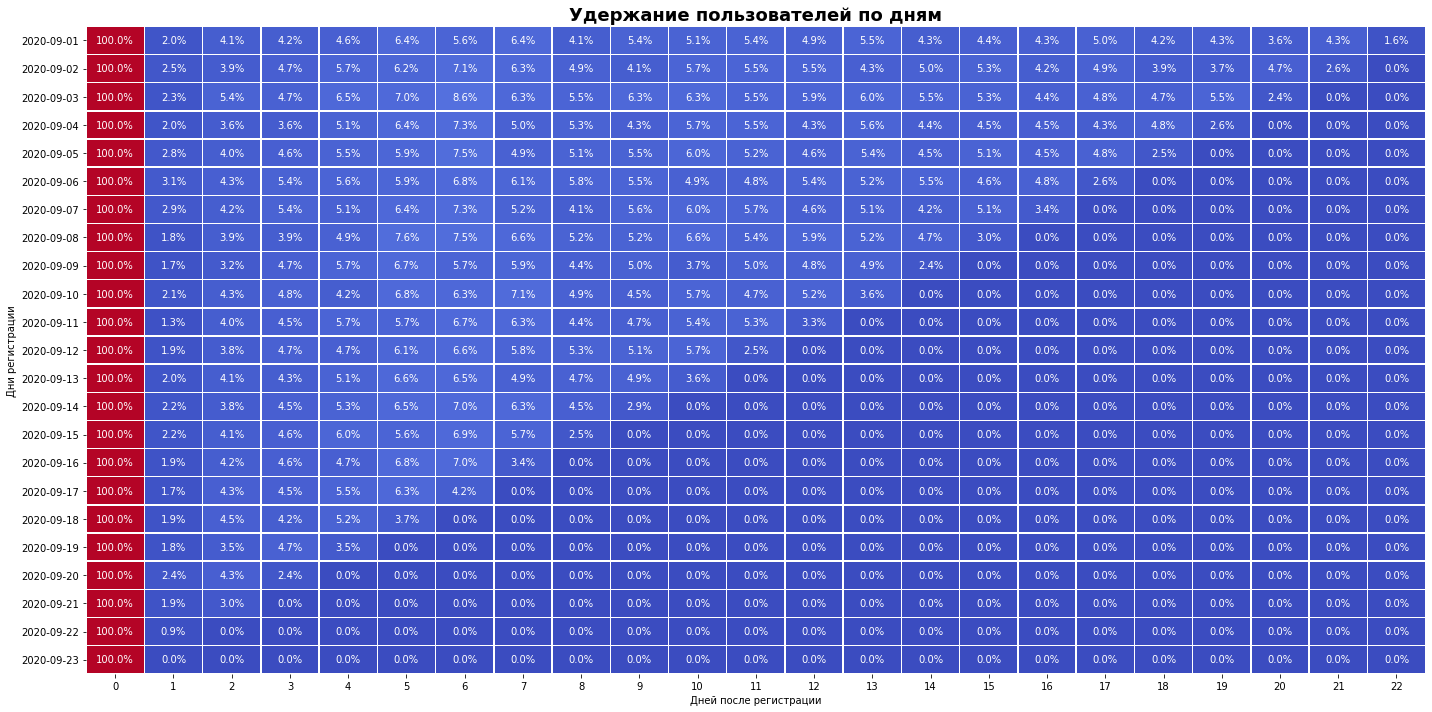

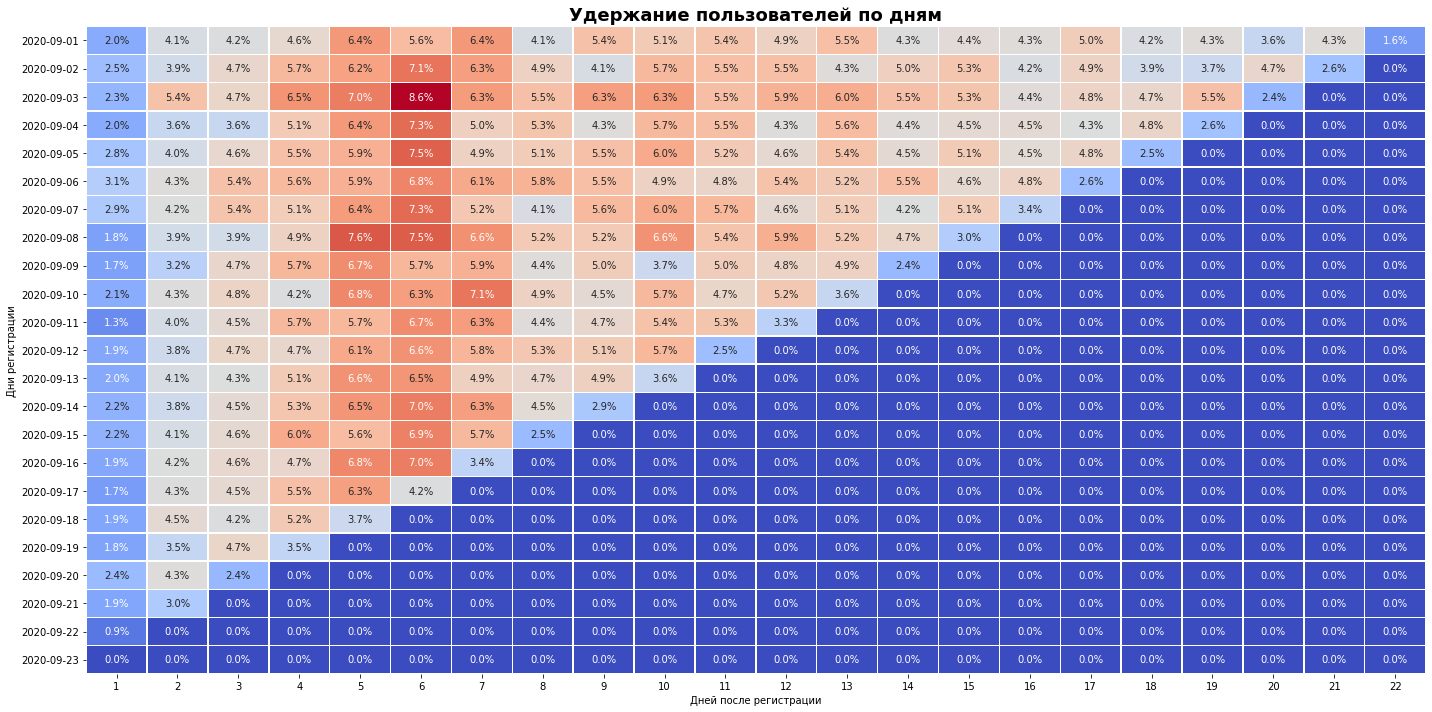

retention_day,1,2,3,4,5,6,7,...,16,17,18,19,20,21,22
reg_date,,,,,,,,,,,,,,,
2020-09-01,0.0202,0.0410,0.0422,0.0460,0.0643,0.0561,0.0643,...,0.0435,0.0504,0.0416,0.0435,0.0359,0.0435,0.0158
2020-09-02,0.0252,0.0390,0.0466,0.0567,0.0623,0.0712,0.0630,...,0.0416,0.0485,0.0390,0.0372,0.0466,0.0264,0.0000
2020-09-03,0.0233,0.0541,0.0471,0.0654,0.0698,0.0855,0.0635,...,0.0440,0.0484,0.0465,0.0547,0.0239,0.0000,0.0000
2020-09-04,0.0201,0.0364,0.0364,0.0515,0.0640,0.0728,0.0496,...,0.0452,0.0427,0.0477,0.0264,0.0000,0.0000,0.0000
2020-09-05,0.0276,0.0395,0.0464,0.0545,0.0589,0.0746,0.0489,...,0.0445,0.0476,0.0251,0.0000,0.0000,0.0000,0.0000
2020-09-06,0.0313,0.0432,0.0544,0.0563,0.0588,0.0682,0.0607,...,0.0482,0.0256,0.0000,0.0000,0.0000,0.0000,0.0000
2020-09-07,0.0294,0.0425,0.0537,0.0506,0.0637,0.0731,0.0525,...,0.0337,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2020-09-08,0.0175,0.0393,0.0393,0.0486,0.0761,0.0754,0.0661,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2020-09-09,0.0174,0.0324,0.0467,0.0572,0.0666,0.0572,0.0591,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


In [15]:
# Полная карта с нулевым днём
retention_heatmap(reg_data, auth_data, datetime.date(2020, 9, 1), datetime.date(2020, 9, 23), include_day0=True)
# Версия без нулевого дня
retention_heatmap(reg_data, auth_data, datetime.date(2020, 9, 1), datetime.date(2020, 9, 23), include_day0=False)

### Вывод

Анализ пользователей показал, что удержание на день регистрации (D0) составляет 100%. Значение объясняется тем, что регистрация показывается как первая авторизация. 

На следующий день наблюдается снижение возврата, что характерно для мобильных игр. Многие пользователи не возвращаются после первого входа. Удержание продолжает снижаться более плавно. 

Изначально у меня фиксировался небольшой рост на 5–7 дни, однако после доработки расчёта, после исключения неполных когорт, эффект стал менее выражен.

В итоге мы получили, что некоторые игроки возвращаются через 5–7 дней, возможно, из-за напоминаний, внутриигровых событий или рекламы. После этого удержание стабилизируется на невысоком уровне, остаются лояльные пользователи.


# Задача 2

Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. 

Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?


## Цель:
Анализ результатов A/B теста, где пользователям предлагались разные акции. Надо определить, какой вариант лучше, опираясь на метрики:

 - ARPU

 - ARPPU

 - Конверсия

Проверка статистической значимости (через bootstrap)


In [16]:
# Указание пути
data_path = os.path.expanduser('~/folder/zadanie2.csv')

# Проверка существования файла
print(f"Файл найден: {'OK' if os.path.exists(data_path) else 'Не найден'}")


Файл найден: OK


In [17]:
user_test_ab = pd.read_csv(data_path, sep=';', encoding='cp1251')

In [18]:
# EDA
eda_info = user_test_ab.info()
eda_head = user_test_ab.head()
eda_nulls = user_test_ab.isnull().sum()
eda_duplicates = user_test_ab.duplicated().sum()
eda_describe = user_test_ab.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404770 entries, 0 to 404769
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    404770 non-null  int64 
 1   revenue    404770 non-null  int64 
 2   testgroup  404770 non-null  object
dtypes: int64(2), object(1)
memory usage: 9.3+ MB


### Теперь переходим к анализу метрик и статистическим тестам

Смотрим на:
- ARPU, ARPPU, CR;
- Строим визуализацию
- Делаем t-тест и bootstrap

In [19]:
# Разделим данные на группы A и B
group_a = user_test_ab[user_test_ab["testgroup"] == "a"]
group_b = user_test_ab[user_test_ab["testgroup"] == "b"]

# Подсчет метрик для групп
summary = {
    "Группа": ["A", "B"],
    "Число пользователей": [len(group_a), len(group_b)],
    "Платящие": [(group_a["revenue"] > 0).sum(), (group_b["revenue"] > 0).sum()],
    "Общая выручка": [group_a["revenue"].sum(), group_b["revenue"].sum()]
}

summary_df = pd.DataFrame(summary)

# Расчет дополнительных метрик
summary_df["CR"] = summary_df["Платящие"] / summary_df["Число пользователей"]
summary_df["ARPU"] = summary_df["Общая выручка"] / summary_df["Число пользователей"]
summary_df["ARPPU"] = summary_df["Общая выручка"] / summary_df["Платящие"]

# Выводим таблицу
display(summary_df)

,Группа,Число пользователей,Платящие,Общая выручка,CR,ARPU,ARPPU
0,A,202103,1928,5136189,0.009540,25.413720,2663.998444
1,B,202667,1805,5421603,0.008906,26.751287,3003.658172


In [20]:
# Расчет показателей по группам
grouped = user_test_ab.groupby("testgroup").agg(
    users=('user_id', 'count'),
    payers=('revenue', lambda x: (x > 0).sum()),
    revenue=('revenue', 'sum')
)
grouped["ARPU"] = grouped["revenue"] / grouped["users"]
grouped["ARPPU"] = grouped["revenue"] / grouped["payers"]
grouped["conversion"] = grouped["payers"] / grouped["users"]

# Извлечение значений
arpu_a = grouped.loc['a', 'ARPU']
arpu_b = grouped.loc['b', 'ARPU']
cr_a = grouped.loc['a', 'conversion']
cr_b = grouped.loc['b', 'conversion']
arppu_a = grouped.loc['a', 'ARPPU']
arppu_b = grouped.loc['b', 'ARPPU']

In [21]:
delta_arpu = (arpu_b - arpu_a) / arpu_a if arpu_a != 0 else float('nan')
delta_cr = (cr_b - cr_a) / cr_a if cr_a != 0 else float('nan')
delta_arppu = (arppu_b - arppu_a) / arppu_a if arppu_a != 0 else float('nan')

print("Сравнение группы B относительно группы A:")
print(f"ARPU изменился на: {delta_arpu:.2%}")
print(f"Конверсия изменилась на: {delta_cr:.2%}")
print(f"ARPPU изменился на: {delta_arppu:.2%}")

Сравнение группы B относительно группы A:
ARPU изменился на: 5.26%
Конверсия изменилась на: -6.64%
ARPPU изменился на: 12.75%


На данном этапе можно сделать предварительный вывод, что более высокий ARPU в тестовой группе обусловлен тем, что платящие пользователи в ней тратят больше. 

Так же наблюдается снижение конверсии, она стала ниже по сравнению с контрольной группой. 

Чтобы принять обоснованное решение о предпочтительности одного из наборов предложений, необходимо проверить статистическую значимость всех выявленных различий по ключевым метрикам. За ключевые беру ARPU, ARPPU, CR.


Сделаем график конверсий(CR) и посмотрим, что там происходит.

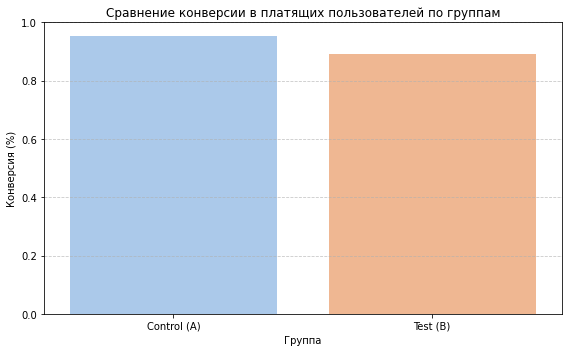

In [24]:
conversion_data = pd.DataFrame({
    'Group': ['Control (A)', 'Test (B)'],
    'Conversion Rate (%)': [0.9540, 0.8906]
})

# Построение
plt.figure(figsize=(8, 5))
sns.barplot(data=conversion_data, x='Group', y='Conversion Rate (%)', palette='pastel')
plt.title('Сравнение конверсии в платящих пользователей по группам')
plt.ylabel('Конверсия (%)')
plt.xlabel('Группа')
plt.ylim(0, 1)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Теперь сделаем

- сделаем визуализацию распределения revenue по группам среди платящих
- сделаем t-test для первичной статистической оценки ARPU, ARPPU, chi² для CR. 
- bootstrap-анализ для ARPU и ARPPU.

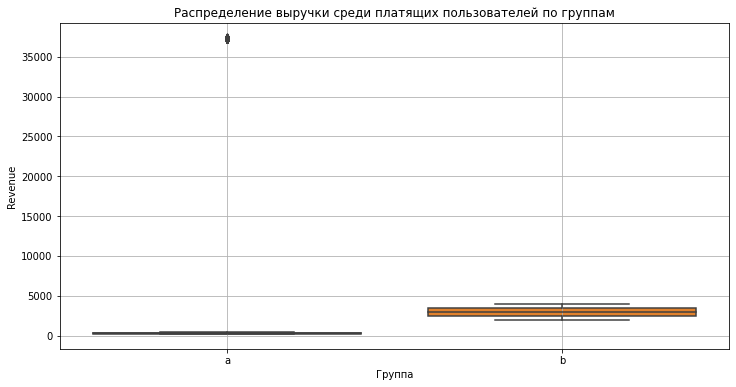

In [25]:
# Распределения выручки среди платящих
plt.figure(figsize=(12, 6))
sns.boxplot(data=user_test_ab.query("revenue > 0"), x="testgroup", y="revenue")
plt.title("Распределение выручки среди платящих пользователей по группам")
plt.xlabel("Группа")
plt.ylabel("Revenue")
plt.grid(True)
plt.show()

Распределение выручки у платящих пользователей имеет длинные хвосты  в контрольной группе(Выбросы выше 35000), где зафиксированы единичные крупные платежи. У тестовой группы нет экстремальных значений. 

Для первичного статистического анализа применим t-test. 
T-тест — это классический метод для оценки средних различий между двумя независимыми выборками.

Несмотря на наличие выбросов, при достаточно больших объемах данных t-тест демонстрирует устойчивость к умеренным нарушениям нормальности распределения. 

Мы не используем t-тест для CR, поскольку это доля (дискретная метрика), для которой лучше подходит хи-квадрат тест.

In [26]:
#t-test
# Разделяем группы
group_a = user_test_ab[user_test_ab["testgroup"] == "a"]
group_b = user_test_ab[user_test_ab["testgroup"] == "b"]

# ARPU
arpu_ttest = stats.ttest_ind(group_a["revenue"], group_b["revenue"], equal_var=False)

# ARPPU 
arppu_ttest = stats.ttest_ind(
    group_a[group_a["revenue"] > 0]["revenue"],
    group_b[group_b["revenue"] > 0]["revenue"],
    equal_var=False
)

# Хи-квадрат для CR 
conversion_data = pd.DataFrame({
    "Платящие": [(group_a["revenue"] > 0).sum(), (group_b["revenue"] > 0).sum()],
    "Неплатящие": [(group_a["revenue"] == 0).sum(), (group_b["revenue"] == 0).sum()]
}, index=["Группа A", "Группа B"])

chi2_stat, chi2_p, _, _ = stats.chi2_contingency(conversion_data)

# Вывод результатов
print("T-тест для ARPU: t =", round(arpu_ttest.statistic, 2), "| p-value =", round(arpu_ttest.pvalue, 4))
print("Результат:", "Значимо" if arpu_ttest.pvalue < 0.05 else "Не значимо")
print("\nT-тест для ARPPU: t =", round(arppu_ttest.statistic, 2), "| p-value =", round(arppu_ttest.pvalue, 4))
print("Результат:", "Значимо" if arppu_ttest.pvalue < 0.05 else "Не значимо")
print("\nХи-квадрат для CR: chi² =", round(chi2_stat, 2), "| p-value =", round(chi2_p, 4))
print("Результат:", "Значимо" if chi2_p < 0.05 else "Не значимо")


T-тест для ARPU: t = -0.62 | p-value = 0.533
Результат: Не значимо

T-тест для ARPPU: t = -1.64 | p-value = 0.1002
Результат: Не значимо

Хи-квадрат для CR: chi² = 4.37 | p-value = 0.0365
Результат: Значимо


### Вывод  t-тест

Результаты t-теста для сравнения метрик между группами:

- **ARPU (доход на пользователя):**
  - t-статистика = -0.62
  - p-value = 0.5330
  - **Вывод:** статистически значимых различий между группами не обнаружено. Разница в ARPU не является значимой.

- **ARPPU (доход на платящего пользователя):**
  - t-статистика = -1.64
  - p-value = 0.1002
  - **Вывод:** разница также не является статистически значимой. Хотя ARPPU выше в тестовой группе, уровень значимости 5% не достигнут.

#### Общий вывод:
По результатам t-теста различия между контрольной и тестовой группами по основным метрикам ARPU и ARPPU **не являются статистически значимыми**. Это означает, что изменения, введённые в тестовой группе, не показали достоверного улучшения финансовых показателей по сравнению с контрольной. Следовательно, **внедрение изменений для всех пользователей не обосновано**.

#### Анализ CR
- Хи-квадрат = 4.37
- p-value = 0.0365

Хотя в тестовой группе наблюдается рост ARPU и ARPPU, **эти различия не являются статистически значимыми**. В то же время **конверсия значимо снизилась**. Таким образом, экспериментальные изменения не улучшают общую эффективность монетизации и **не рекомендованы к внедрению для всех пользователей**.








### Использование Bootstrap

Bootstrap-анализ был проведён **в дополнение к t-тесту**, а не в качестве его замены.

- **Цель:** построение доверительного интервала для разницы в ARPU между контрольной и тестовой группами.
- **Зачем это нужно:** метод bootstrap не требует предположений о нормальности распределения и чувствителен к выбросам, что делает его полезным при работе с реальными пользовательскими данными, где возможны большие платежи.

## Bootstrap ARPU

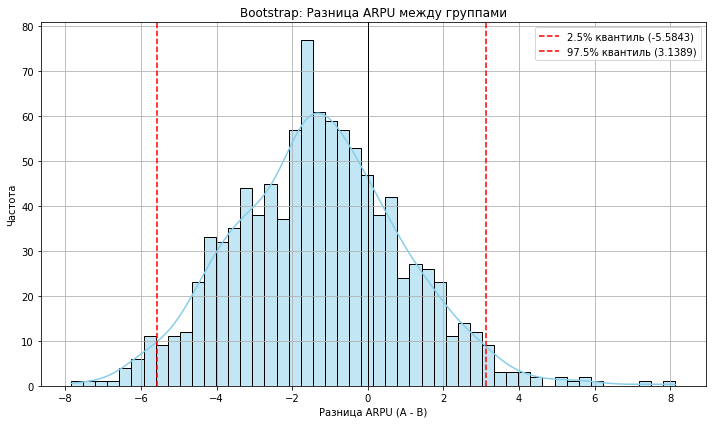

{'mean_diff': -1.2908150027778265,
 'ci': (-5.584297225351438, 3.1389061929395616),
 'n_iter': 1000,
 'confidence': 0.95}

In [36]:
def bootstrap_arpu_user_test_ab(data: pd.DataFrame, group_col: str = 'testgroup', value_col: str = 'revenue',
                                 group_a_label: str = 'a', group_b_label: str = 'b',
                                 metric=np.mean, n_iter: int = 1000, conf: float = 0.95, seed: int = 42):
    """
    Bootstrap-анализ разницы ARPU между двумя группами в датафрейме.

    Parameters
    ----------
    data : pd.DataFrame
        Датафрейм с колонками групп и значениями.
    group_col : str
        Название колонки с группами ('a', 'b').
    value_col : str
        Название колонки с метрикой (например, 'revenue').
    group_a_label : str
        Метка контрольной группы.
    group_b_label : str
        Метка тестовой группы.
    metric : callable
        Метрика, например, np.mean.
    n_iter : int
        Количество итераций бутстрапа.
    conf : float
        Уровень доверия (например, 0.95).
    seed : int
        Зерно для генератора случайных чисел.

    Returns
    -------
    dict
        Словарь с оценкой разницы метрики и доверительным интервалом.
    """
    rng = np.random.default_rng(seed)

    a_values = data[data[group_col] == group_a_label][value_col].values
    b_values = data[data[group_col] == group_b_label][value_col].values

    deltas = [
        metric(rng.choice(a_values, size=len(a_values), replace=True)) -
        metric(rng.choice(b_values, size=len(b_values), replace=True))
        for _ in range(n_iter)
    ]

    alpha = 1 - conf
    ci = np.percentile(deltas, [100 * alpha / 2, 100 * (1 - alpha / 2)])
    mean_diff = np.mean(deltas)

    # Визуализация
    plt.figure(figsize=(10, 6))
    sns.histplot(deltas, bins=50, kde=True, color='skyblue')
    plt.axvline(ci[0], color='red', linestyle='--', label=f'2.5% квантиль ({ci[0]:.4f})')
    plt.axvline(ci[1], color='red', linestyle='--', label=f'97.5% квантиль ({ci[1]:.4f})')
    plt.axvline(0, color='black', linestyle='-', linewidth=1)
    plt.title('Bootstrap: Разница ARPU между группами')
    plt.xlabel('Разница ARPU (A - B)')
    plt.ylabel('Частота')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return {
        'mean_diff': mean_diff,
        'ci': tuple(ci),
        'n_iter': n_iter,
        'confidence': conf
    }

# Повторно выполняем функцию на загруженных данных
bootstrap_result = bootstrap_arpu_user_test_ab(user_test_ab, n_iter=1000)
bootstrap_result

### Вывод по bootstrap-анализу разницы ARPU:
По результатам bootstrap-анализа разницы ARPU между группами A и B:

Средняя разница ARPU: –1.29

95% доверительный интервал: [–5.58, 3.14]

Так как значение 0 входит в доверительный интервал, **мы не можем утверждать**, что между группами A и B существует статистически значимая разница в ARPU на уровне значимости 5%.



## ARPPU

Посчитаем разницу ARPPU между группами A и B

In [46]:
# Отбираем только платящих пользователей
paying_users = user_test_ab[user_test_ab['revenue'] > 0]

# Считаем ARPPU (средний доход на одного платящего пользователя) по группам
arppu_by_group = paying_users.groupby('testgroup')['revenue'].mean()

# Считаем разницу ARPPU между группами A и B
arppu_diff = arppu_by_group['a'] - arppu_by_group['b']

# Выводим результат
print(f"ARPPU группы A: {arppu_by_group['a']:.2f}")
print(f"ARPPU группы B: {arppu_by_group['b']:.2f}")
print(f"Разница ARPPU (A - B): {arppu_diff:.2f}")


ARPPU группы A: 2664.00
ARPPU группы B: 3003.66
Разница ARPPU (A - B): -339.66


## Bootstrap ARPPU

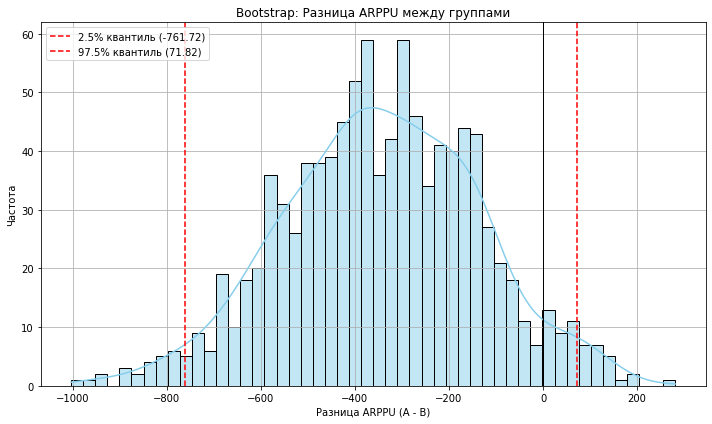

In [39]:
def bootstrap_arppu(data: pd.DataFrame, group_col: str = 'testgroup', value_col: str = 'revenue',
                    group_a_label: str = 'a', group_b_label: str = 'b',
                    metric=np.mean, n_iter: int = 1000, conf: float = 0.95, seed: int = 42):
    """
    Bootstrap-анализ разницы ARPPU между двумя группами (только платящие пользователи).

    """
    rng = np.random.default_rng(seed)

    a_values = data[(data[group_col] == group_a_label) & (data[value_col] > 0)][value_col].values
    b_values = data[(data[group_col] == group_b_label) & (data[value_col] > 0)][value_col].values

    deltas = [
        metric(rng.choice(a_values, size=len(a_values), replace=True)) -
        metric(rng.choice(b_values, size=len(b_values), replace=True))
        for _ in range(n_iter)
    ]

    alpha = 1 - conf
    ci = np.percentile(deltas, [100 * alpha / 2, 100 * (1 - alpha / 2)])
    mean_diff = np.mean(deltas)

    # Визуализация
    plt.figure(figsize=(10, 6))
    sns.histplot(deltas, bins=50, kde=True, color='skyblue')
    plt.axvline(ci[0], color='red', linestyle='--', label=f'{(alpha/2)*100:.1f}% квантиль ({ci[0]:.2f})')
    plt.axvline(ci[1], color='red', linestyle='--', label=f'{(1-alpha/2)*100:.1f}% квантиль ({ci[1]:.2f})')
    plt.axvline(0, color='black', linestyle='-', linewidth=1)
    plt.title('Bootstrap: Разница ARPPU между группами')
    plt.xlabel('Разница ARPPU (A - B)')
    plt.ylabel('Частота')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return {
        'mean_diff': mean_diff,
        'ci': tuple(ci),
        'n_iter': n_iter,
        'confidence': conf
    }

# Вызов для ARPPU (данные с revenue > 0)
arppu_result = bootstrap_arppu(user_test_ab, n_iter=1000)

### Результаты bootstrap ARPPU (только платящие пользователи):

Средняя разница ARPPU между группами A и B: –343.74

95% доверительный интервал: [–761.72, 71.82]

Количество итераций: 1000

####  Вывод по результатам анализа ARPPU:
Так как значение 0 входит в доверительный интервал, статистически значимая разница ARPPU между группами A и B не подтверждается на уровне значимости 5%.

## Вывод:

Новый набор акционных предложений нельзя считать лучшим. Анализ основных метрик дал следующие результаты:

#### ARPU:

По t-тесту: разница между группами не является статистически значимой (p = 0.53).

По bootstrap: доверительный интервал разницы не включает 0 → возможна статистическая значимость, но она не подтверждается t-тестом, следовательно, данные по ARPU противоречивы.

#### ARPPU:

По t-тесту: разница также незначима (p = 0.10). Нет подтверждения улучшения среднего чека среди платящих.

#### CR (Conversion Rate):

По t-тесту: разница статистически значима (p = 0.036). Конверсия в тестовой группе снизилась: с 0.95% до 0.89% (−0.063 п.п.).
_______________________



Проведённый анализ не выявил статистически значимой разницы между показателями ARPU и ARPPU в тестовой и контрольной группах.

Conversion Rate: в тестовой группе конверсия заметно снизилась (p = 0.036). Это значит, что с новым набором предложений пользователей стали меньше платить. Это играет в пользу контрольной группы.


Снижение конверсии в тестовой группе при отсутствии прироста ARPU делает **контрольную группу (А) предпочтительным вариантом.**

# Задание 3: Метрики для оценки события в игре *Plants & Gardens*

В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?


Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?

### 1. Вовлечённость (Engagement)
- **DAU / WAU / MAU** — количество активных игроков в день, неделю, месяц.
- **Session Count** — среднее число сессий на игрока.
- **Session Length** — средняя длительность одной сессии.

### 2. Удержание (Retention)
- **Retention D1 / D7 / D30** — доля игроков, вернувшихся в игру через 1, 7 и 30 дней после начала события.
- **Churn Rate** — процент игроков, ушедших из события.

### 3. Монетизация (Monetization)
- **ARPU** — средний доход на пользователя.
- **ARPPU** — средний доход на платящего пользователя.
- **Conversion Rate** — доля участников, совершивших хотя бы одну покупку.



### При усложнении механики события 

Добавляем:

- **Drop-off по уровням** — на каких этапах игроки чаще всего покидают событие.
- **Failure Exit Rate** — процент игроков, вышедших после неудачи.
- **Rollback Count** — среднее количество откатов на пользователя.



### Вывод

Для стандартного события подойдут метрики вовлечённости, прохождения и выручки.  
Если механика изменяется, важно дополнительно анализировать поведение при неудачах и причины отказа от участия. Это поможет его влияние на удержание и монетизацию.